# Setup

In [1]:
# Import Libraries
import numpy as np
import pyrfume
from rdkit import Chem
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
# Import SMILES and SMARTS
odorants = pd.read_csv("data/odorants.csv")
smarts = pd.read_csv("data/omp8x_smarts42.csv") # 59 x 43
smiles = pd.read_csv("data/omp8x_smiles.txt") # 58 x 1 shape
# Import MODRED Features
mordred = pd.read_csv("data/mordred_features.csv") # 59 x 932 shape

In [2]:
latent_space = pd.read_csv("data/latentSpace")
# Latent Space from the AUTOENCODER
odorants = pd.read_csv("data/odorants.csv")
# Modified Odorants
data_1h = pd.read_csv("data/omp8x_1_high.txt").T
data_2h = pd.read_csv("data/omp8x_2_high.txt").T
data_3h = pd.read_csv("data/omp8x_3_high.txt").T
data_4h = pd.read_csv("data/omp8x_4_high.txt").T
data_1l = pd.read_csv("data/omp8x_1_low.txt").T
data_2l = pd.read_csv("data/omp8x_2_low.txt").T
data_3l = pd.read_csv("data/omp8x_3_low.txt").T
data_4l = pd.read_csv("data/omp8x_4_low.txt").T

data_vector = [data_1h, data_2h, data_3h, data_4h, data_1l, data_2l, data_3l, data_4l]
names = ["OB 1 High", "OB 2 High", "OB 3 High", "OB 4 High", "OB 1 Low", "OB 2 Low", "OB 3 Low", "OB 4 Low"]

idx_gloms = data_vector

# Set the Data with Odorant Index
for i in idx_gloms:
    i.set_index(odorants['Group_name'], inplace=True)

### Cosine Distance Function

In [3]:
def cosine_distance_matrix(data):

    """
    This function calculates cosine distance much like the scipy package but we use the formula
    and we also round the cosine similarity as a bug in the code produced negative distances manually
    and the scipy packages produced missing values because of division by zero.
    """

    x = data.iloc[:,:].values # removes the data labels and turns to numpy array as it worked this way
    sumCol = np.sum(x**2, axis = 1)
    norms= np.sqrt(sumCol)

    dist_mat = np.zeros((x.shape[0], x.shape[0]))

    for i in range(x.shape[0]):
        for j in range(x.shape[0]):

            if norms[i] == 0 and norms[j] == 0: # they are perfeclty correlated then
                dist_mat[i,j] = 1.0
                continue
            # however if the 0 vecotors are due to measurement errors then this shouldn't add up, haha, but maybe keep the low value.
            if norms[i] == 0 or norms[j] == 0:
                dist_mat[i,j] = 1e-25
                continue
                
            dot_product = np.dot(x[i], x[j])
            cosine_similarity = dot_product / (norms[i] * norms[j])
            cosine_similarity = np.round(cosine_similarity, 5) # it seems we must round to acoid negative values in hte next step. 
            # If both are similar then what we have is a 1-1.00...01 which ends up a miniscule negative value. 
            # This would make it by definition not a cosine distance matrix
            cosine_distance = 1 - cosine_similarity
            
            dist_mat[i,j] = cosine_distance

    return dist_mat

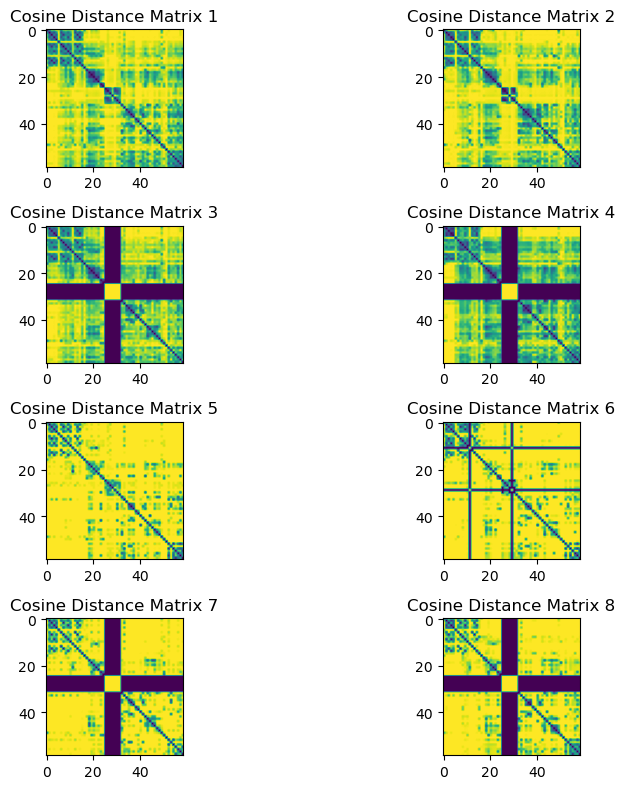

In [4]:
dist_list = []
for data in data_vector:
    dist_list.append(cosine_distance_matrix(data))

fig, axes = plt.subplots(4,2, figsize = (10,8))
axes = axes.ravel()

for i, data in enumerate(dist_list):
    axes[i].imshow(data, cmap="viridis")
    axes[i].set_title(f"Cosine Distance Matrix {i+1}")

plt.tight_layout()
plt.show()

# First 4 are high concentrations, the latter are low concentrations

In [5]:
from scipy.stats import spearmanr
# Compare the matrices
def compareMatrices(m1, m2):
    # Flattens the matrices and compares their rank correlation
    m1 = m1.flatten()
    m2 = m2.flatten()

    rho, p = spearmanr(m1, m2)

    return rho, p

for i in range(len(dist_list)):
    for j in range(len(dist_list) - 1, -1, -1):
        r, p = compareMatrices(dist_list[i], dist_list[j])
        print(f"For Pairs {i + 1} and {j + 1} we have {r}; {p}")

For Pairs 1 and 8 we have 0.1334510298166894; 2.6543080461606647e-15
For Pairs 1 and 7 we have 0.037035335574555614; 0.02888520986511236
For Pairs 1 and 6 we have 0.38161808370990535; 4.415049669756944e-121
For Pairs 1 and 5 we have 0.5903974999553596; 0.0
For Pairs 1 and 4 we have 0.2645267052555634; 8.016255215506697e-57
For Pairs 1 and 3 we have 0.2427675887587789; 7.152665633935633e-48
For Pairs 1 and 2 we have 0.8376754435343359; 0.0
For Pairs 1 and 1 we have 1.0; 0.0
For Pairs 2 and 8 we have 0.11887812907561375; 1.9747746635143346e-12
For Pairs 2 and 7 we have 0.058601744824157136; 0.0005417138065632814
For Pairs 2 and 6 we have 0.3404763175399701; 3.286278087351467e-95
For Pairs 2 and 5 we have 0.5225767859602267; 2.8968074045188725e-243
For Pairs 2 and 4 we have 0.25543204214142196; 5.6302498877359e-53
For Pairs 2 and 3 we have 0.2680385397514384; 2.3852816743354083e-58
For Pairs 2 and 2 we have 1.0; 0.0
For Pairs 2 and 1 we have 0.837675443534336; 0.0
For Pairs 3 and 8 we hav

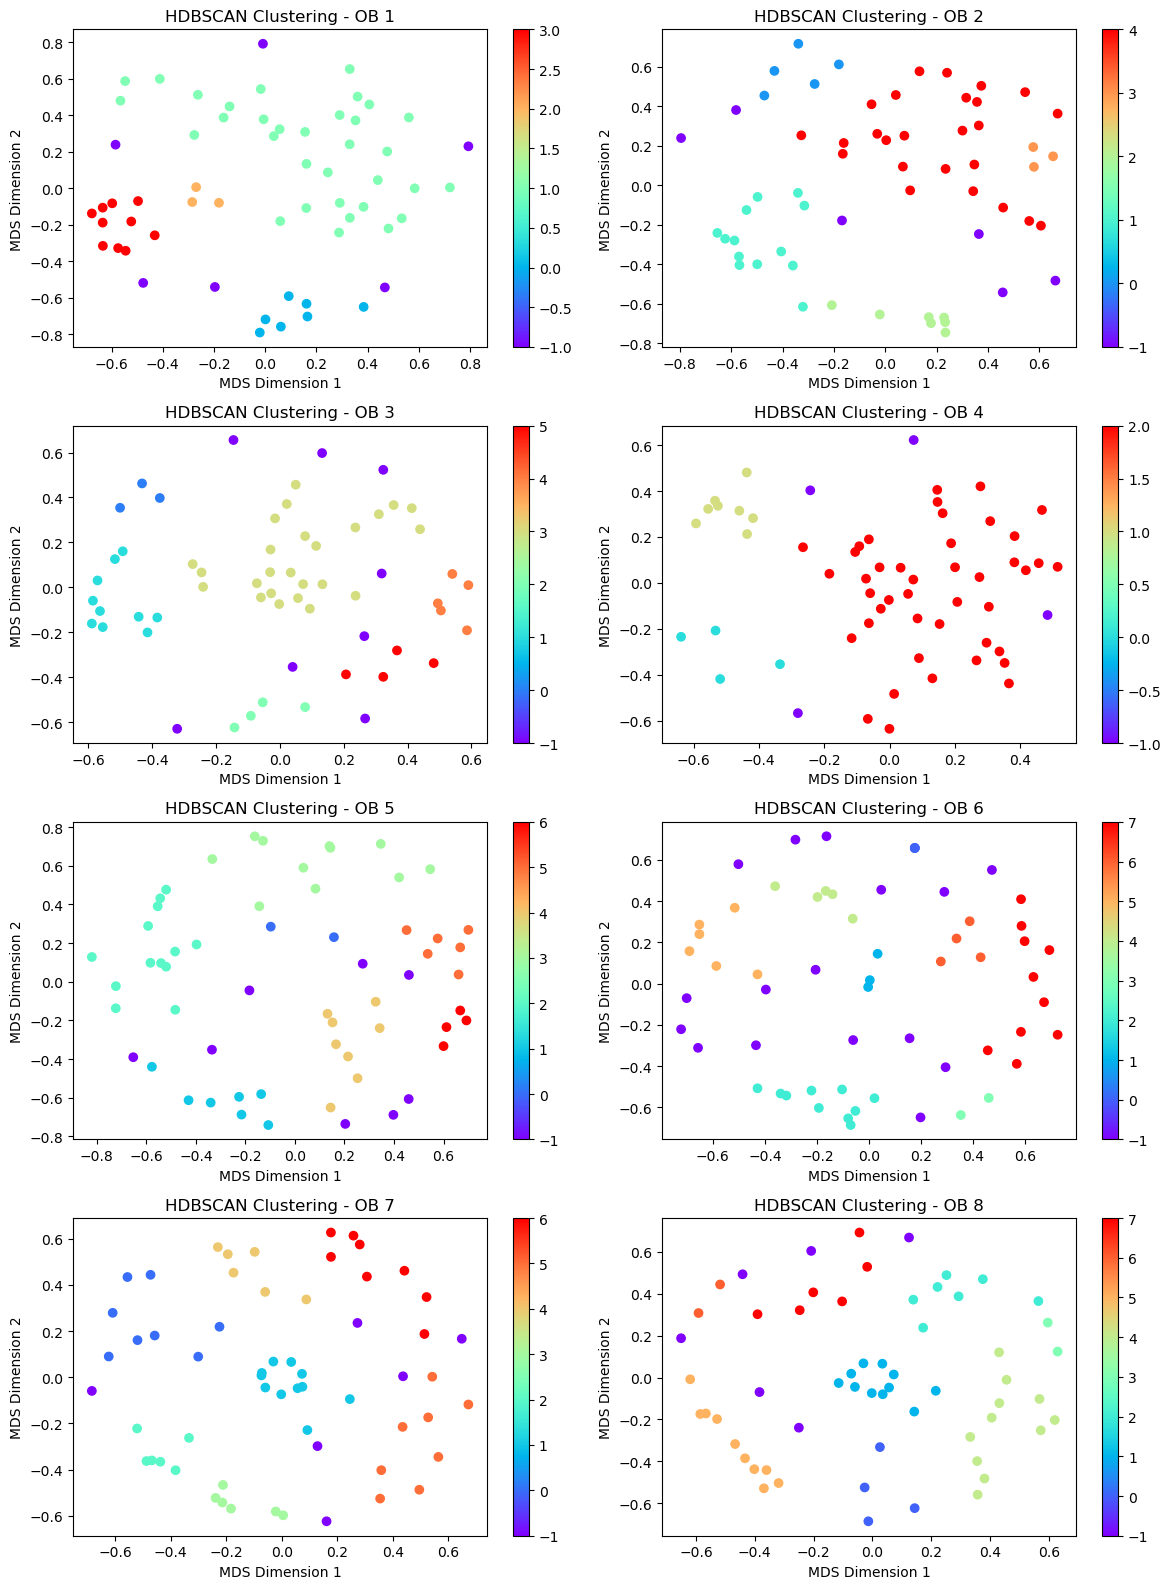

In [7]:
import hdbscan
from sklearn.manifold import MDS

cluster_labels = []
reduced_dists = []

fig, axes = plt.subplots(4,2, figsize = (12,16))
axes = axes.flatten()
for i in range(len(dist_list)):

    mds = MDS(n_components = 2, random_state= 42, dissimilarity ="precomputed")
    data = mds.fit_transform(dist_list[i])
    clusterer = hdbscan.HDBSCAN(min_cluster_size=2, cluster_selection_epsilon= 0.175)
    clusterer.fit(data)
    # print(clusterer.labels_)
    reduced_dists.append(data)
    cluster_labels.append(clusterer.labels_)


    scatter_plot = axes[i].scatter(data[:, 0], data[:, 1], c=clusterer.labels_, cmap='rainbow')
    plt.colorbar(scatter_plot, ax = axes[i])


    axes[i].set_title(f"HDBSCAN Clustering - OB {i+1}")
    axes[i].set_xlabel("MDS Dimension 1")
    axes[i].set_ylabel("MDS Dimension 2")
plt.tight_layout()
plt.show()

# Let's store a list of hte results we have so far.
clust_results = []

for mat in range(8):
    group_names = data_1h.index
    glom = pd.DataFrame( { 'group': group_names, 'odorant': odorants["Odorant"],'cluster': cluster_labels[mat],'d1': reduced_dists[mat][:,0], 'd2': reduced_dists[mat][:,1]}) # odorants column 3 is odor names
    clust_results.append(glom)


In [8]:
for mat in range(8):
    g1 = clust_results[mat]
    print(f"---" * 20)
    print(f"OB {mat + 1}")
    for i in range(len(np.unique(g1["cluster"]))):
        print(f"In cluster {i -1} we have {np.sum(g1["cluster"] == i-1)}")

------------------------------------------------------------
OB 1
In cluster -1 we have 6
In cluster 0 we have 7
In cluster 1 we have 33
In cluster 2 we have 3
In cluster 3 we have 10
------------------------------------------------------------
OB 2
In cluster -1 we have 6
In cluster 0 we have 5
In cluster 1 we have 13
In cluster 2 we have 7
In cluster 3 we have 3
In cluster 4 we have 25
------------------------------------------------------------
OB 3
In cluster -1 we have 8
In cluster 0 we have 3
In cluster 1 we have 10
In cluster 2 we have 4
In cluster 3 we have 25
In cluster 4 we have 5
In cluster 5 we have 4
------------------------------------------------------------
OB 4
In cluster -1 we have 4
In cluster 0 we have 4
In cluster 1 we have 8
In cluster 2 we have 43
------------------------------------------------------------
OB 5
In cluster -1 we have 8
In cluster 0 we have 2
In cluster 1 we have 7
In cluster 2 we have 13
In cluster 3 we have 11
In cluster 4 we have 8
In cluster 5

In [9]:
def summary_table(data, cluster = 1):
    b1 = data[data["cluster"] == cluster]
    summary = pd.DataFrame({
        'count': b1['group'].value_counts(),
        'percentage': b1['group'].value_counts(normalize=True).mul(100).round(1)
    })

    print(f"OB {i+1}")
    print(summary)
    print("---" * 20)

# Most populated clusters are in order of groups:
    # 1, 4, 3, 2, (2,7), ,(2,7), 1, (4,5)
# Second Most Populated
    # 3,1,1,1,3,7, (0,5,6), 1

big_groups = [ 1, 4, 3, 2, 2, 2, 1, 4]
sec_groups = [3,1,1,1,3,7,5,1]
for i in range(8):
    summary_table(clust_results[i], cluster= sec_groups[i])

OB 1
                 count  percentage
group                             
Carboxylic Acid      4        40.0
Aldehyde             3        30.0
Ester                3        30.0
------------------------------------------------------------
OB 2
                 count  percentage
group                             
Carboxylic Acid      5        38.5
Aldehyde             5        38.5
Ester                3        23.1
------------------------------------------------------------
OB 3
                 count  percentage
group                             
Carboxylic Acid      4        40.0
Aldehyde             3        30.0
Ester                3        30.0
------------------------------------------------------------
OB 4
                 count  percentage
group                             
Carboxylic Acid      5        62.5
Ester                2        25.0
Aldehyde             1        12.5
------------------------------------------------------------
OB 5
          count  percentage
gro